In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [2]:
bs = 64
n_epoch = 40
z_dim = 100
mnist_dim = 784
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True, drop_last=True)

In [3]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_
    
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 4*4*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.conv(y_)
        return y_

In [4]:
D = Discriminator().to(device)
G = Generator().to(device)

In [5]:
G

Generator(
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): ReLU()
  )
  (conv): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [6]:
D

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): AvgPool2d(kernel_size=4, stride=4, padding=0)
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [7]:
criterion = nn.BCELoss()

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

D_real = torch.ones([bs, 1]).to(device) # Discriminator Label to real
D_fake = torch.zeros([bs, 1]).to(device) # Discriminator Label to fake

In [8]:
D_losses, G_losses = [], []
real_scores, fake_scores = [], []
fixed_noise = Variable(torch.randn(bs, z_dim).to(device))

In [9]:
for epoch in range(1, n_epoch+1):
    for batch_idx, (x, _) in enumerate(train_loader):
        # train discriminator on real data
        D_output = D(x.to(device))
        real_score = torch.mean(D_output)
        D_x_loss = criterion(D_output, D_real)
        
        # train discriminator on fake data
        z = torch.randn(bs, z_dim).to(device)
        D_output = D(G(z))
        fake_score = torch.mean(D_output)
        D_z_loss = criterion(D_output, D_fake)
        
        D_loss = D_x_loss + D_z_loss
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        
        # train generator
        z = torch.randn(bs, z_dim).to(device)
        D_output = D(G(z))
        G_loss = criterion(D_output, D_real)
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        
        if batch_idx % 100 == 99:
            D_losses.append(D_loss)
            G_losses.append(G_loss)
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            print('epoch[%d/%d]batch[%d/%d]: loss_d: %.3f, loss_g: %.3f, D(x): %.3f, D(G(z)): %.3f' %
                 (epoch, n_epoch, batch_idx, len(train_loader), D_loss.item(), G_loss.item(), real_score.item(), fake_score.item()))
    
    # save models
    torch.save(G.state_dict(), './models/dcgan/G.pth')
    torch.save(D.state_dict(), './models/dcgan/D.pth')
    
    # save fake images
    with torch.no_grad():
        generated = G(fixed_noise)
        save_image(generated.view(generated.size(0), 1, 28, 28), './samples/dcgan/sample_%03d.png' % epoch, 8)

epoch[1/40]batch[99/937]: loss_d: 1.032, loss_g: 1.155, D(x): 0.647, D(G(z)): 0.446
epoch[1/40]batch[199/937]: loss_d: 1.228, loss_g: 0.857, D(x): 0.451, D(G(z)): 0.346
epoch[1/40]batch[299/937]: loss_d: 1.134, loss_g: 0.755, D(x): 0.491, D(G(z)): 0.341
epoch[1/40]batch[399/937]: loss_d: 1.067, loss_g: 1.115, D(x): 0.648, D(G(z)): 0.466
epoch[1/40]batch[499/937]: loss_d: 1.281, loss_g: 0.498, D(x): 0.414, D(G(z)): 0.323
epoch[1/40]batch[599/937]: loss_d: 1.061, loss_g: 1.019, D(x): 0.567, D(G(z)): 0.384
epoch[1/40]batch[699/937]: loss_d: 1.139, loss_g: 0.780, D(x): 0.623, D(G(z)): 0.482
epoch[1/40]batch[799/937]: loss_d: 0.998, loss_g: 1.474, D(x): 0.757, D(G(z)): 0.507
epoch[1/40]batch[899/937]: loss_d: 0.877, loss_g: 1.027, D(x): 0.673, D(G(z)): 0.378
epoch[2/40]batch[99/937]: loss_d: 0.880, loss_g: 1.095, D(x): 0.656, D(G(z)): 0.361
epoch[2/40]batch[199/937]: loss_d: 0.729, loss_g: 1.353, D(x): 0.638, D(G(z)): 0.239
epoch[2/40]batch[299/937]: loss_d: 0.892, loss_g: 0.901, D(x): 0.56

epoch[11/40]batch[799/937]: loss_d: 0.519, loss_g: 2.948, D(x): 0.795, D(G(z)): 0.227
epoch[11/40]batch[899/937]: loss_d: 0.510, loss_g: 1.581, D(x): 0.754, D(G(z)): 0.180
epoch[12/40]batch[99/937]: loss_d: 0.550, loss_g: 1.524, D(x): 0.797, D(G(z)): 0.246
epoch[12/40]batch[199/937]: loss_d: 0.434, loss_g: 1.124, D(x): 0.853, D(G(z)): 0.221
epoch[12/40]batch[299/937]: loss_d: 0.452, loss_g: 2.538, D(x): 0.771, D(G(z)): 0.156
epoch[12/40]batch[399/937]: loss_d: 0.556, loss_g: 1.245, D(x): 0.644, D(G(z)): 0.070
epoch[12/40]batch[499/937]: loss_d: 0.425, loss_g: 2.445, D(x): 0.934, D(G(z)): 0.269
epoch[12/40]batch[599/937]: loss_d: 0.401, loss_g: 1.713, D(x): 0.793, D(G(z)): 0.139
epoch[12/40]batch[699/937]: loss_d: 0.366, loss_g: 1.340, D(x): 0.819, D(G(z)): 0.140
epoch[12/40]batch[799/937]: loss_d: 0.387, loss_g: 2.461, D(x): 0.752, D(G(z)): 0.083
epoch[12/40]batch[899/937]: loss_d: 0.611, loss_g: 1.597, D(x): 0.628, D(G(z)): 0.098
epoch[13/40]batch[99/937]: loss_d: 0.815, loss_g: 2.420

epoch[22/40]batch[499/937]: loss_d: 0.501, loss_g: 1.544, D(x): 0.766, D(G(z)): 0.179
epoch[22/40]batch[599/937]: loss_d: 0.501, loss_g: 2.613, D(x): 0.887, D(G(z)): 0.291
epoch[22/40]batch[699/937]: loss_d: 0.580, loss_g: 3.153, D(x): 0.884, D(G(z)): 0.305
epoch[22/40]batch[799/937]: loss_d: 0.667, loss_g: 1.987, D(x): 0.837, D(G(z)): 0.332
epoch[22/40]batch[899/937]: loss_d: 0.497, loss_g: 1.606, D(x): 0.797, D(G(z)): 0.209
epoch[23/40]batch[99/937]: loss_d: 0.542, loss_g: 2.504, D(x): 0.915, D(G(z)): 0.315
epoch[23/40]batch[199/937]: loss_d: 0.325, loss_g: 1.191, D(x): 0.863, D(G(z)): 0.143
epoch[23/40]batch[299/937]: loss_d: 0.408, loss_g: 2.176, D(x): 0.972, D(G(z)): 0.297
epoch[23/40]batch[399/937]: loss_d: 0.539, loss_g: 2.460, D(x): 0.675, D(G(z)): 0.089
epoch[23/40]batch[499/937]: loss_d: 0.988, loss_g: 2.957, D(x): 0.959, D(G(z)): 0.550
epoch[23/40]batch[599/937]: loss_d: 0.542, loss_g: 3.072, D(x): 0.879, D(G(z)): 0.300
epoch[23/40]batch[699/937]: loss_d: 0.429, loss_g: 1.73

epoch[33/40]batch[199/937]: loss_d: 0.567, loss_g: 2.889, D(x): 0.957, D(G(z)): 0.362
epoch[33/40]batch[299/937]: loss_d: 0.675, loss_g: 4.345, D(x): 0.875, D(G(z)): 0.357
epoch[33/40]batch[399/937]: loss_d: 0.497, loss_g: 2.678, D(x): 0.738, D(G(z)): 0.122
epoch[33/40]batch[499/937]: loss_d: 0.275, loss_g: 2.135, D(x): 0.948, D(G(z)): 0.184
epoch[33/40]batch[599/937]: loss_d: 0.367, loss_g: 2.800, D(x): 0.850, D(G(z)): 0.158
epoch[33/40]batch[699/937]: loss_d: 0.605, loss_g: 3.442, D(x): 0.729, D(G(z)): 0.173
epoch[33/40]batch[799/937]: loss_d: 0.343, loss_g: 3.087, D(x): 0.780, D(G(z)): 0.063
epoch[33/40]batch[899/937]: loss_d: 0.223, loss_g: 2.401, D(x): 0.971, D(G(z)): 0.164
epoch[34/40]batch[99/937]: loss_d: 0.278, loss_g: 1.912, D(x): 0.835, D(G(z)): 0.077
epoch[34/40]batch[199/937]: loss_d: 0.445, loss_g: 2.223, D(x): 0.709, D(G(z)): 0.071
epoch[34/40]batch[299/937]: loss_d: 0.894, loss_g: 3.220, D(x): 0.958, D(G(z)): 0.493
epoch[34/40]batch[399/937]: loss_d: 0.190, loss_g: 2.60

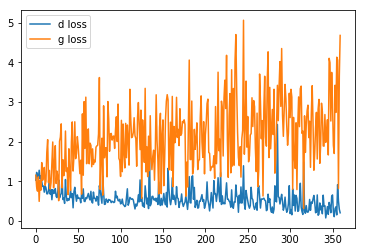

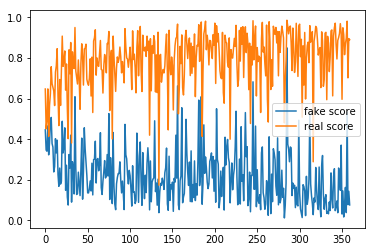

In [10]:
plt.figure()
plt.plot(D_losses, label='d loss')
plt.plot(G_losses, label='g loss')    
plt.legend()
plt.savefig('loss_dcgan.png')
plt.show()

plt.figure()
plt.plot(fake_scores, label='fake score')
plt.plot(real_scores, label='real score')    
plt.legend()
plt.savefig('score_dcgan.png')
plt.show()